In [ ]:
import os
import librosa
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_directory = '/content/drive/MyDrive/Colab Notebooks/'
file_name = 'custom_features_3_s.csv'

In [ ]:
def split_audio(y, sr, num_segments=10):
    audio_length = len(y)
    segment_length = audio_length // num_segments

    segments = []

    for i in range(num_segments):
        start = i * segment_length
        end = (i + 1) * segment_length
        segments.append(y[start:end])

    return segments

In [ ]:
def extract_features(y, sr):
    # y, sr = librosa.load(file_path)
    
    # Extract features using librosa
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)
    harmonic, percussive = librosa.effects.hpss(y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    
    # Calculate mean and variance values of features
    features = np.hstack([np.mean(mfcc, axis=1), np.var(mfcc, axis=1),
                      np.mean(chroma), np.var(chroma),
                      np.mean(spec_contrast), np.var(spec_contrast),
                      np.mean(tonnetz), np.var(tonnetz),
                      np.mean(spec_centroid), np.var(spec_centroid),
                      np.mean(spec_bandwidth), np.var(spec_bandwidth),
                      np.mean(spec_rolloff), np.var(spec_rolloff),
                      np.mean(zero_crossing_rate), np.var(zero_crossing_rate),
                      np.mean(rms), np.var(rms),
                      np.mean(harmonic), np.var(harmonic),
                      np.mean(percussive), np.var(percussive),
                      tempo])

    return features

In [ ]:
def process_directory(input_dir, genre):
    data = []
    num_segments = 10
    for file in os.listdir(input_dir):
        try:
          if file.endswith('.wav'):
              file_path = os.path.join(input_dir, file)
              y, sr = librosa.load(file_path)
              segments = split_audio(y, sr, num_segments)
              for i, segment in enumerate(segments):
                  features = extract_features(segment, sr)
                  data.append([f"{file_name}_seg{i+1}", genre] + list(features))
                  # features = extract_features(file_path)
                  # data.append([file, genre] + list(features))
        except:
            print('An error occured for file: ' + file.__str__())
    return data

In [ ]:
input_directories = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]
genres = input_directories
input_directories = [os.path.join(base_directory, 'Data', 'genres_original', genre) for genre in genres]

In [13]:
all_data = []
for directory, genre in zip(input_directories, genres):
    data = process_directory(directory, genre)
    all_data.extend(data)

An error occured for file: blues.00011.wav


<ipython-input-12-da88d6ba61dc>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


An error occured for file: jazz.00054.wav


In [14]:
columns = ['filename', 'label'] + [f'feature_{i}' for i in range(len(all_data[0]) - 2)]
df = pd.DataFrame(all_data, columns=columns)

In [15]:
df.to_csv(os.path.join(base_directory, 'Data', file_name), index=False)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
file = base_directory + 'Data/' + file_name
df = pd.read_csv(file)

In [18]:
y = df['label']
unique_genres = y.unique()
le = LabelEncoder()
y = le.fit_transform(y)

X = df.drop('label', axis=1).drop('filename', axis=1)

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
params = {
    'learning_rate': 0.3,
    'n_estimators': 250,
    'max_depth': 4,
    # 'tree_method': 'gpu_hist',
    'gamma': 0,
    'colsample_bytree': 1,
    'subsample': 1,
     'min_child_weight': 3,
     'reg_alpha': 0,
    'reg_lambda': 1.5,
    'max_delta_step': 1
}

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
model = XGBClassifier(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


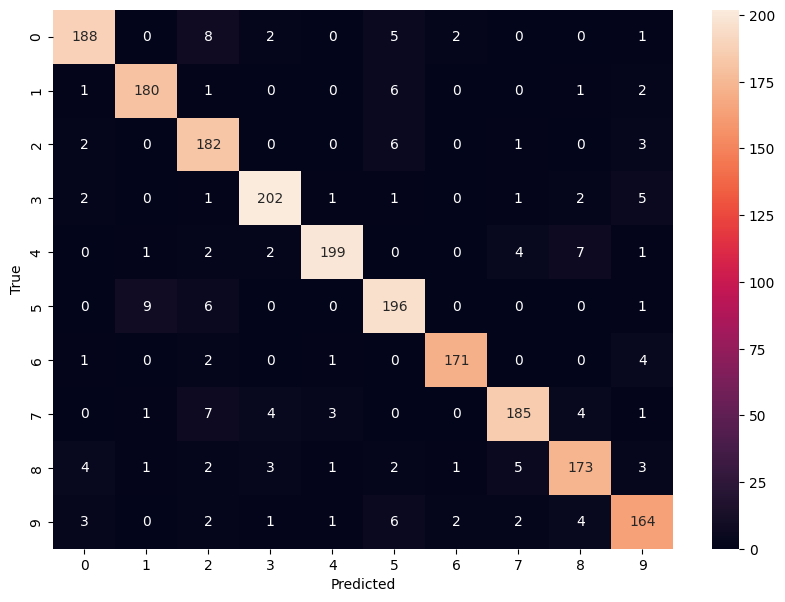

In [22]:
genres = model.classes_
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=genres, yticklabels=genres)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [23]:
print(classification_report(y_test, y_pred, target_names=unique_genres))

              precision    recall  f1-score   support

       blues       0.94      0.91      0.92       206
   classical       0.94      0.94      0.94       191
     country       0.85      0.94      0.89       194
       disco       0.94      0.94      0.94       215
      hiphop       0.97      0.92      0.94       216
        jazz       0.88      0.92      0.90       212
       metal       0.97      0.96      0.96       179
         pop       0.93      0.90      0.92       205
      reggae       0.91      0.89      0.90       195
        rock       0.89      0.89      0.89       185

    accuracy                           0.92      1998
   macro avg       0.92      0.92      0.92      1998
weighted avg       0.92      0.92      0.92      1998



In [ ]:
param_grid = {
    
}
gbm = XGBClassifier(**params) # GradientBoostingClassifier
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best hyperparameters:", best_params)
print("Best accuracy score:", best_score)

best_model = XGBClassifier({**best_params, **params}, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
